In [1]:
import pandas as pd
import math

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


Propertycrime = α + Population + Population2 + Murder + Robbery

The 'population' variable is already set for you, but you will need to create the last three features. Robbery and Murder are currently continuous variables. For this model, please use these variables to create categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0. You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready. Don't forget basic data cleaning procedures, either! Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

In [2]:
df = pd.read_csv('C:\\Users\\david\Desktop\\thinkful datasets\\table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv', header=4,)

df
display(df.columns)

data= pd.DataFrame(df) 

needed_data = data.loc[:, ['City','Population', 'Property\ncrime','Murder and\nnonnegligent\nmanslaughter', 'Robbery','Burglary']]
needed_data.columns = ['City','Population','Property_Crime', 'Murder', 'Robbery', 'Burglary']

needed_data = needed_data.dropna()

needed_data.Robbery = needed_data.Robbery.where(needed_data.Robbery == 0, 1)
needed_data.Murder = needed_data.Murder.where(needed_data.Murder == 0, 1)

needed_data["population2"] = needed_data["Population"]**2

needed_data = needed_data[np.abs(needed_data.Population-needed_data.Population.mean())<=(2*needed_data.Population.std())] #keep only the ones that are within +2 to -2 standard deviations in the column 'Data'.

needed_data.head(5)

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

,City,Population,Property_Crime,Murder,Robbery,Burglary,population2
0,Adams Village,1861.000,12.000,0.000,0.000,2.000,3463321.000
1,Addison Town and Village,2577.000,24.000,0.000,0.000,3.000,6640929.000
2,Akron Village,2846.000,16.000,0.000,0.000,1.000,8099716.000
3,Albany,97956.000,4090.000,1.000,1.000,705.000,9595377936.000
4,Albion Village,6388.000,223.000,0.000,1.000,53.000,40806544.000


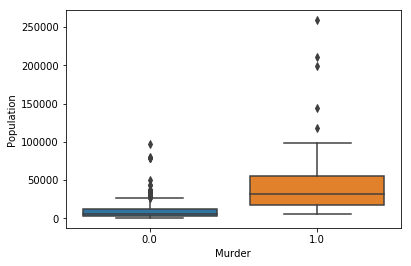

In [3]:
sns.boxplot(
    needed_data.Murder,
    needed_data.Population,
)
plt.xlabel('Murder')
plt.ylabel('Population')
plt.show()

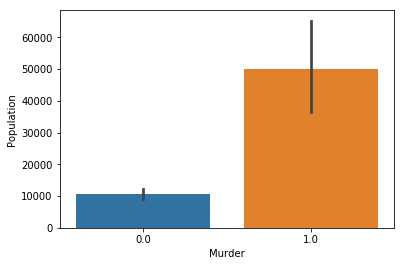

In [4]:
sns.barplot(x='Murder', y='Population', data=needed_data)
plt.show()

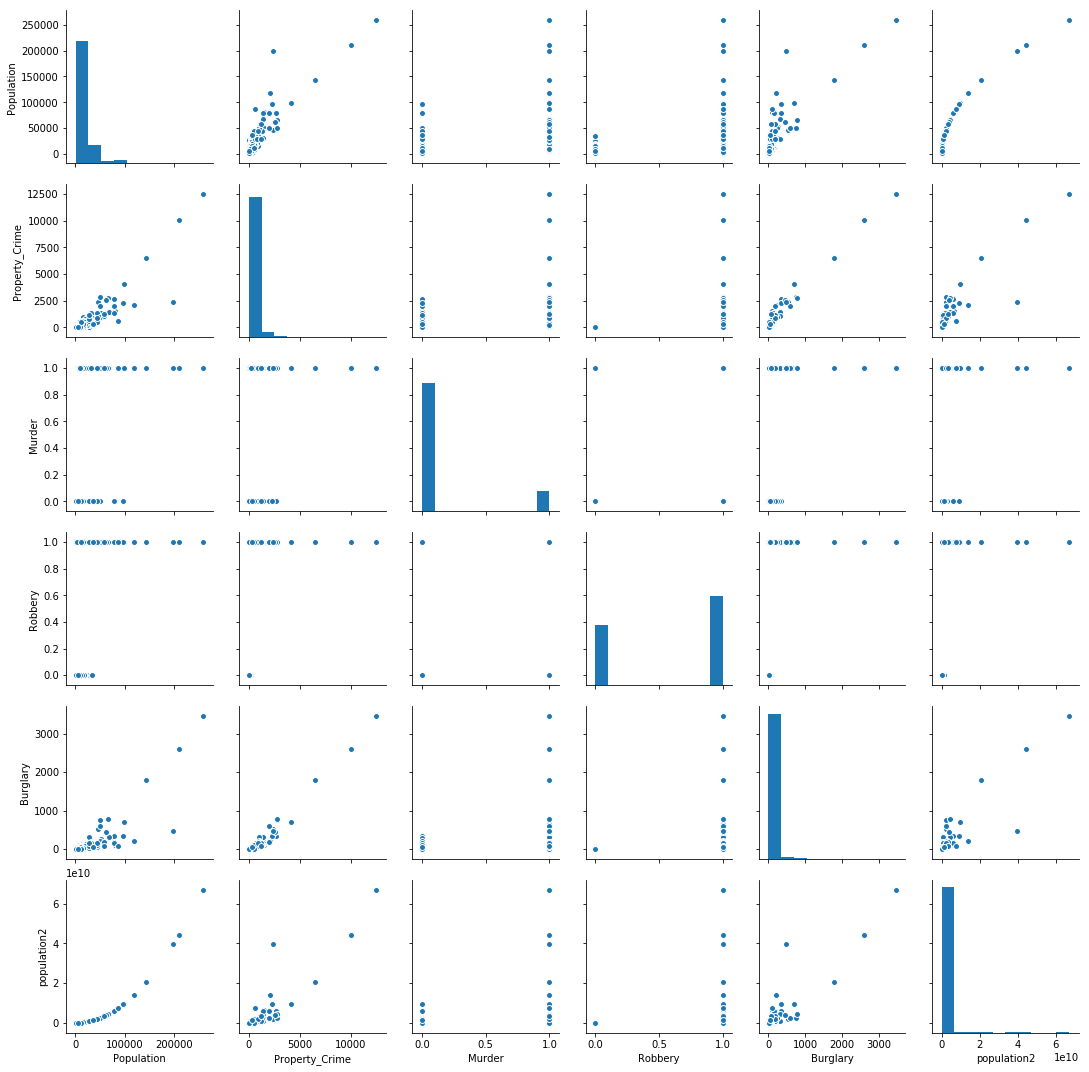

In [5]:
sns.pairplot(needed_data)

In [6]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = needed_data['Property_Crime'].values.reshape(-1, 1)
X = needed_data[['Population','Robbery','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[9.43446764e-03 6.25784109e+01 4.95287897e+00 2.99691963e+00]]

Intercept: 
 [-19.28319047]

R-squared:
0.9774741731454328


In [7]:
# Fit the model to our data using the formula.
lm = smf.ols('Property_Crime ~ Population+Robbery+Murder+Burglary', data=needed_data).fit()

In [8]:
lm.params

Intercept    -19.283
Population     0.009
Robbery       62.578
Murder         4.953
Burglary       2.997
dtype: float64

In [9]:
lm.pvalues

Intercept    0.152
Population   0.000
Robbery      0.001
Murder       0.862
Burglary     0.000
dtype: float64

In [10]:
lm.rsquared

0.977474173145433

In [11]:
# Instantiate and fit our model. 
#MODEL REMOVED MURDER
regr2 = linear_model.LinearRegression()
Y2 = needed_data['Property_Crime'].values.reshape(-1, 1)
X2 = needed_data[['Population','Robbery','Burglary']]
regr2.fit(X2, Y2)

# Inspect the results.
print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X2, Y2))


Coefficients: 
 [[9.46236207e-03 6.31254818e+01 2.99697961e+00]]

Intercept: 
 [-19.37542499]

R-squared:
0.9774721838032118


In [12]:
# Fit the model to our data using the formula.
lm2 = smf.ols('Property_Crime ~ Population+Robbery+Burglary', data=needed_data).fit()

In [13]:
lm2.pvalues

Intercept    0.150
Population   0.000
Robbery      0.001
Burglary     0.000
dtype: float64

### Now let's examine the Multivariate Normality.
The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed. Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

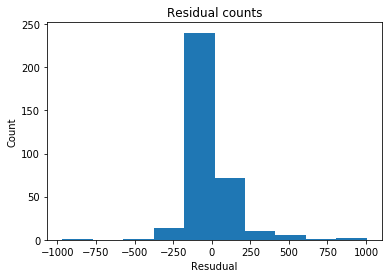

In [14]:

# Extract predicted values.# Extract 
predicted = regr.predict(X).ravel()
actual = needed_data['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Resudual')
plt.ylabel('Count')
plt.show()




We are looking for a normal distribution for the residuals and have not achieved that. Therefore, we will need to do some transformations

### Homoscedasticity
The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or homoscedastic.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance. This leads to overconfidence in the accuracy of your model's predictions.

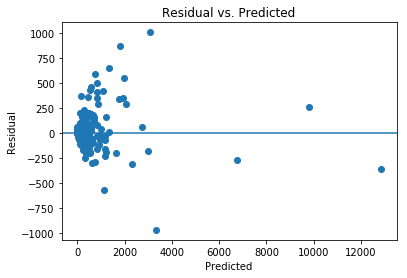

In [15]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [16]:
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Robbery,Murder,Burglary
Population,1.000,0.344,0.503,0.820
Robbery,0.344,1.000,0.311,0.197
Murder,0.503,0.311,1.000,0.402
Burglary,0.820,0.197,0.402,1.000


It seems that there are outliers larger than NYC making the data skewed